In [4]:
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import shuffle
from string import punctuation

from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import tree
from sklearn import neural_network

# get the book list
bookList = gutenberg.fileids()
# print(bookList)
# books=bookList[0,3,4,5,6,7,8,11]
books = np.array(bookList[0])
books = np.append(books, bookList[3:8])
books = np.append(books, bookList[11])

# print(books)
# segment

def sampling(number_samples, sample_size, book_name):
    labeled_records = []
    book = gutenberg.raw(book_name)
    # print(book)
    # tokenize the material of the book
    raw_words = nltk.word_tokenize(book)
    # print(raw_words)
    # Prepare 200 documents for each book
    headers = random.sample(range(0, len(raw_words)), number_samples)

    for header in headers:
        segment = raw_words[header:(header + sample_size + 1)]
        labeled_records.append((segment, book_name))
    return labeled_records


def data_cleaning(sample_words):
    # customize the punctuation list by adding extra string
    extra_string = "'-- ``'' "
    update_punctuation = punctuation + extra_string
    # customize the stopwords list by adding extra stopwords
    sw = stopwords.words('english')
    extra_stopwords = "n't", "'s", "ar't", "'d", "'ll", "i'll"
    sw.extend(extra_stopwords)
    # Remove punctuation
    remove_punct_words = [w for w in sample_words if w not in update_punctuation]
    # Change all letters to lowercase
    lowercase_words = [w.lower() for w in remove_punct_words]
    # Strip "_" at the beginning or end of a word
    strip_words = [w.strip('_') for w in lowercase_words]
    # Remember digits/numbers (keeps only words)
    remove_number_words = [w for w in strip_words if w.isalpha()]
    # Remove stop words
    final_words = [w for w in remove_number_words if w not in sw]
    return final_words
if __name__ == "__main__":
    try_number_samples = 200
    try_sample_size = 100
    final_list = []
    for book_name in books:
        # print (book_name)
        labeled_list = sampling(try_number_samples, try_sample_size, book_name)
        cleaned_labeled_list = []

        for samples in labeled_list:
            book_name = samples[1]

            cleaned_seg = data_cleaning(samples[0])
            cleaned_labeled_seg = (cleaned_seg, book_name)
            # print(cleaned_labeled_seg)
            cleaned_labeled_list.append(cleaned_labeled_seg)
        # print(cleaned_labeled_list)
        final_list = final_list + cleaned_labeled_list
    # shuffle the list
    shuffle(final_list)
    #print(final_list)

    docs = []
    tags = []

    # word lemmatization
    lem = WordNetLemmatizer()
    for labeled_doc in final_list:
        docs.append(lem.lemmatize(' '.join(labeled_doc[0])))
        tags.append(labeled_doc[1])
    print(docs)
    # import data to dictionary
    dic = {'Text': docs, 'File_name': tags}
    # apply pandas data frame
    df = pd.DataFrame(dic)
#     print(df)
    # df.columns = ['Text', 'File_name']
    df['book_id'] = df['File_name'].factorize()[0]
    book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
    book_to_id = dict(book_id_df.values)
    id_to_book = dict(book_id_df[['book_id', 'File_name']].values)

['handle pail slip around neck could get rid pail take ran making bad matter worse neighbors green forest see fix make fun could stand felt humiliated another way saying shamed yes sir buster felt shamed eyes neighbors', 'whilst read surprise lamentation lamb mother leaned shoulder read words interrupted finished first stanza another knock door postman another letter sir arthur sisters came intention much disappointed find old harper rendered vain came lend farmer good family money pay', 'delicious berries shade big bush old pasture stop think whether right buster fond berries second greedy little eyes saw pailful forgot everything feast waiting right nose think anything right wrong helping berries ever seen together one time life', 'ar moab lords high places arnon woe thee moab thou art undone people chemosh hath given sons escaped daughters captivity unto sihon king amorites shot heshbon perished even unto dibon laid waste even unto nophah reacheth unto medeba thus israel dwelt land 

In [5]:
# feature engineering： TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.book_id
# list the feature names (in this case the unigram and bigrams in the sample, as we chose ngram_range=(1, 2))
#print(tfidf.get_feature_names())
# check feature shape
print(features.shape)

# find the terms that are the most correlated with each of the book
# pick 2 terms
N = 2
for File_name, book_id in sorted(book_to_id.items()):
    features_chi2 = chi2(features, labels == book_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(File_name))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


(1400, 38185)
# 'austen-emma.txt':
  . Most correlated unigrams:
. harriet
. emma
  . Most correlated bigrams:
. miss fairfax
. miss woodhouse
# 'bible-kjv.txt':
  . Most correlated unigrams:
. lord
. unto
  . Most correlated bigrams:
. lord god
. said unto
# 'blake-poems.txt':
  . Most correlated unigrams:
. infant
. weep
  . Most correlated bigrams:
. human form
. little lamb
# 'bryant-stories.txt':
  . Most correlated unigrams:
. alligator
. jackal
  . Most correlated bigrams:
. little red
. little jackal
# 'burgess-busterbrown.txt':
  . Most correlated unigrams:
. bear
. buster
  . Most correlated bigrams:
. farmer brown
. buster bear
# 'carroll-alice.txt':
  . Most correlated unigrams:
. mock
. alice
  . Most correlated bigrams:
. mock turtle
. said alice
# 'edgeworth-parents.txt':
  . Most correlated unigrams:
. francisco
. archer
  . Most correlated bigrams:
. said francisco
. attorney case


In [6]:
#train a model
# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['File_name'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
# Test the model
# testing_file = "plagues long continuance sore sicknesses long continuance moreover bring upon thee diseases"
testing_file = "yes mammy said epaminondas next day epaminondas went see auntie gave"
print(clf.predict(count_vect.transform([testing_file])))
df[df['Text'] == "yes mammy said epaminondas next day epaminondas went see auntie gave pound butter mammy fine fresh sweet butter epaminondas wrapped leaves put hat put hat head came along home hot day pretty soon butter began melt melted melted melted ran epaminondas forehead ran"]


['bryant-stories.txt']


,Text,File_name,book_id


In [7]:
tf = TfidfVectorizer()
text_tf = tf.fit_transform(docs)

svm = svm.SVC(kernel='linear', C=1)
dt = tree.DecisionTreeClassifier()
mlp = neural_network.MLPClassifier()
knn = neighbors.KNeighborsClassifier(n_neighbors=2)
nb = MultinomialNB()

scaler = preprocessing.StandardScaler(with_mean=False).fit(text_tf)
text_tf_transf = scaler.transform(text_tf)


svm_tfidf_scores = cross_val_score(svm, text_tf_transf, tags, cv=10)
knn_tfidf_scores = cross_val_score(knn, text_tf, tags, cv=10)
mlp_tfidf_scores = cross_val_score(mlp, text_tf_transf, tags, cv=10)
dt_tfidf_scores = cross_val_score(dt, text_tf_transf, tags, cv=10)
nb_tfidf_scores = cross_val_score(nb, text_tf_transf, tags, cv=10)



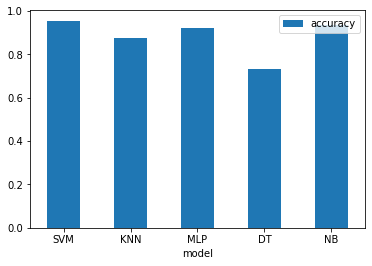

In [8]:
scores = []
scores.append(svm_tfidf_scores.mean())
scores.append(knn_tfidf_scores.mean())
scores.append(mlp_tfidf_scores.mean())
scores.append(dt_tfidf_scores.mean())
scores.append(nb_tfidf_scores.mean())
df1 = pd.DataFrame({'accuracy':scores, 'model':['SVM','KNN','MLP','DT','NB']})
df1.plot.bar(x='model', y='accuracy', rot=0)
plt.show()

[0.9428571428571428, 0.8357142857142857, 0.9428571428571428, 0.7857142857142857, 0.95]
[0.9571428571428572, 0.8857142857142857, 0.9142857142857143, 0.75, 0.95]
[0.9571428571428572, 0.85, 0.9428571428571428, 0.7714285714285715, 0.9357142857142857]
[0.9571428571428572, 0.9, 0.95, 0.8, 0.9571428571428572]
[0.9714285714285714, 0.8928571428571429, 0.9142857142857143, 0.7571428571428571, 0.9571428571428572]
[0.9714285714285714, 0.8785714285714286, 0.9214285714285714, 0.75, 0.9214285714285714]
[0.9285714285714286, 0.8571428571428571, 0.9, 0.7, 0.9071428571428571]
[0.9571428571428572, 0.8714285714285714, 0.9071428571428571, 0.7071428571428572, 0.9214285714285714]
[0.9642857142857143, 0.9071428571428571, 0.9357142857142857, 0.6642857142857143, 0.9571428571428572]
[0.95, 0.8785714285714286, 0.9071428571428571, 0.65, 0.9214285714285714]


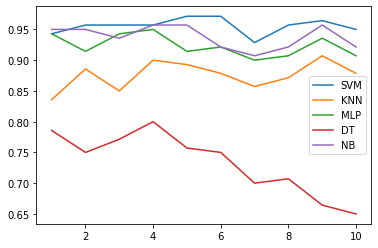

In [9]:

scores.append(svm_tfidf_scores)
scores.append(knn_tfidf_scores)
scores.append(mlp_tfidf_scores)
scores.append(dt_tfidf_scores)
scores.append(nb_tfidf_scores)
scores = [svm_tfidf_scores, knn_tfidf_scores, mlp_tfidf_scores, dt_tfidf_scores,nb_tfidf_scores]
score = []
sc = []
for i in range(0,10):
    sc = [svm_tfidf_scores[i], knn_tfidf_scores[i], mlp_tfidf_scores[i], dt_tfidf_scores[i],nb_tfidf_scores[i]]
    print(sc)
    score.append(sc)
df2 = pd.DataFrame(score, index=[i for i in range(1,11)], columns=['SVM','KNN','MLP','DT','NB'])
# df2 = df2.cumsum()
df2.plot()
plt.show()

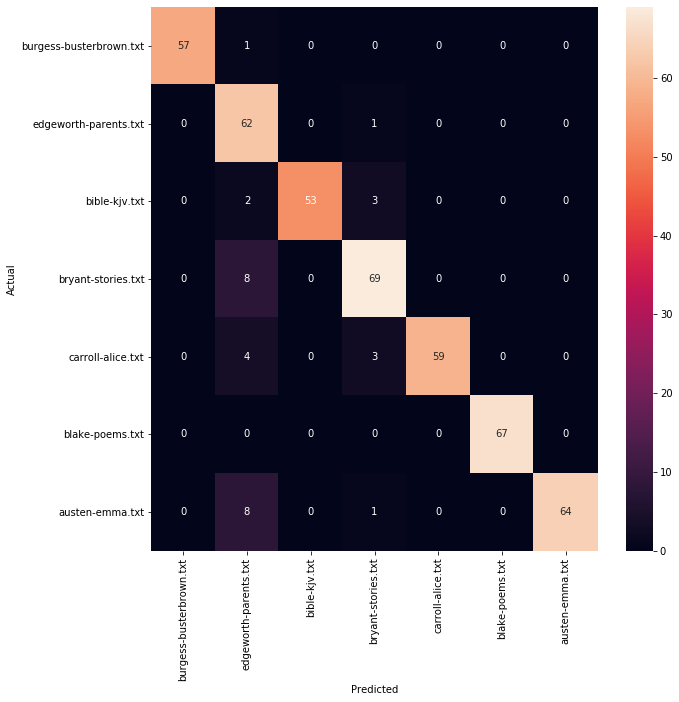

In [15]:
# Model Evaluation
from sklearn import svm
import seaborn as sns
model = svm.SVC(kernel='linear', C=1)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=book_id_df.File_name.values, yticklabels=book_id_df.File_name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#  book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
#     book_to_id = dict(book_id_df.values)
#     id_to_book = dict(book_id_df[['book_id', 'File_name']].values)

In [23]:
from IPython.display import display
for predicted in book_id_df.book_id:
  for actual in book_id_df.book_id:
#     print(predicted,actual, conf_mat[actual, predicted])
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_book[actual], id_to_book[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['File_name', 'Text']])
      print('')

'bible-kjv.txt' predicted as 'edgeworth-parents.txt' : 2 examples.


,File_name,Text
64,bible-kjv.txt,ground fierceness rage neither believeth sound...
1253,bible-kjv.txt,much bold speak word without fear indeed preac...



'bryant-stories.txt' predicted as 'edgeworth-parents.txt' : 8 examples.


,File_name,Text
1084,bryant-stories.txt,well pondered beetle continued homeward way ta...
141,bryant-stories.txt,free live palace every night quite alone come ...
27,bryant-stories.txt,say word would much move mouth grateful ducks ...
960,bryant-stories.txt,said gold hidden orchard dig margaret new orle...
533,bryant-stories.txt,laws epaminondas got end string bread mammy sa...
156,bryant-stories.txt,left every penny different orphan asylums city...
420,bryant-stories.txt,crimson every day dry wither weak scarcely cli...
1293,bryant-stories.txt,oh brother eagle brother eagle tell us seems f...



'carroll-alice.txt' predicted as 'edgeworth-parents.txt' : 4 examples.


,File_name,Text
466,carroll-alice.txt,door knocked sort use knocking said footman tw...
353,carroll-alice.txt,hour quite dry dodo suddenly called race crowd...
140,carroll-alice.txt,ago would feel simple sorrows find pleasure si...
667,carroll-alice.txt,party placed along course two three away began...



'austen-emma.txt' predicted as 'edgeworth-parents.txt' : 8 examples.


,File_name,Text
1159,austen-emma.txt,overcome considerations child given care wealt...
1151,austen-emma.txt,wonder bring declaration must wish anywhere el...
1200,austen-emma.txt,appeared play well considerable taste know not...
583,austen-emma.txt,concerns jane next words ever see skin smoothn...
1078,austen-emma.txt,warfare loved cloth laid fashion youth convict...
1229,austen-emma.txt,errand air foppery nonsense could approve acco...
651,austen-emma.txt,ashamed bear remember aye remember except savi...
252,austen-emma.txt,praise skin used cavil wanting colour clearnes...



'bible-kjv.txt' predicted as 'bryant-stories.txt' : 3 examples.


,File_name,Text
260,bible-kjv.txt,mean men eased ye burdened equality time abund...
881,bible-kjv.txt,grant petition perform request let king haman ...
1359,bible-kjv.txt,set sea right side east end south huram made p...



'carroll-alice.txt' predicted as 'bryant-stories.txt' : 3 examples.


,File_name,Text
1295,carroll-alice.txt,going happen next first tried look make coming...
1118,carroll-alice.txt,except tiny golden key first thought might bel...
760,carroll-alice.txt,soup seemed listening went hours think twelve ...
